In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
import os,sys,csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import interp
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def load_data_TF2(indel_list,data_path): # cell type specific  ## random samples for reactome is not enough, need borrow some from keggp
    import random
    import numpy as np
    xxdata_list = []
    yydata = []
    count_set = [0]
    count_setx = 0
    for i in indel_list:#len(h_tf_sc)):
        xdata = np.load(data_path+'/Nxdata_tf' + str(i) + '.npy')
        ydata = np.load(data_path+'/ydata_tf' + str(i) + '.npy')
        for k in range(len(ydata)):
            xxdata_list.append(xdata[k,:,:,:])
            yydata.append(ydata[k])
        count_setx = count_setx + len(ydata)
        count_set.append(count_setx)
        #print (i,len(ydata))
    yydata_array = np.array(yydata)
    yydata_x = yydata_array.astype('int')
    #print (np.array(xxdata_list).shape)
    return((np.array(xxdata_list),yydata_x,count_set))

In [3]:
csv_reader = csv.reader(open('generatedata/index_train.csv','r'))
trainindex=np.array(list(csv_reader)).shape[0]
csv_reader = csv.reader(open('generatedata/index_test.csv','r'))
testindex=np.array(list(csv_reader)).shape[0]

length_TF_train =int(trainindex-1)
length_TF_test =int(testindex-1)

data_path_train = "NEPDF_data_train"
data_path_test = "NEPDF_data_test"

num_classes = int(2)

train_TF = [i for i in range (length_TF_train)]
test_TF = [i for i in range (length_TF_test)]

(x_train, y_train,count_set_train) = load_data_TF2(train_TF,data_path_train)
(x_test, y_test,count_set) = load_data_TF2(test_TF,data_path_test)
print(x_train.shape, 'x_train samples')
print(x_test.shape, 'x_test samples')

(1152, 32, 32, 1) x_train samples
(336, 32, 32, 1) x_test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_test.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.load_weights("train_model/trained_model.h5")

/home/axiwa/.local/lib/python3.7/site-packages/tensorflow/python/keras/utils/conv_utils.py:233: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


In [5]:
new_model = Sequential()
for layer in model.layers[:-2]:
    #layer.trainable = False                       # freeze param or not
    new_model.add(layer)

new_model.add(Dense(1))
new_model.add(Activation("sigmoid"))
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
new_model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])

In [6]:
save_dir="train_model/"

early_stop = EarlyStopping(monitor="val_accuracy", patience=150, verbose=0, mode="auto")
checkpoint = ModelCheckpoint(filepath=save_dir+'new_weights.hdf5', monitor="val_accuracy", verbose=1, save_best_only=True, mode="auto", period=1)

history = new_model.fit(x=x_train, y=y_train, batch_size=32, epochs=200, validation_split=0.2, shuffle=True, callbacks=[checkpoint, early_stop])
new_model.save_weights(save_dir+"weights.h5")

Epoch 1/200
29/29 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.5537
Epoch 00001: val_accuracy improved from -inf to 0.61039, saving model to train_model/new_weights.hdf5
29/29 [==============================] - 2s 72ms/step - loss: 0.6812 - accuracy: 0.5537 - val_loss: 0.6830 - val_accuracy: 0.6104
Epoch 2/200
29/29 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.5516
Epoch 00002: val_accuracy improved from 0.61039 to 0.62771, saving model to train_model/new_weights.hdf5
29/29 [==============================] - 2s 68ms/step - loss: 0.6617 - accuracy: 0.5516 - val_loss: 0.6643 - val_accuracy: 0.6277
Epoch 3/200
28/29 [===========================>..] - ETA: 0s - loss: 0.6414 - accuracy: 0.5949
Epoch 00003: val_accuracy improved from 0.62771 to 0.66234, saving model to train_model/new_weights.hdf5
29/29 [==============================] - 2s 66ms/step - loss: 0.6405 - accuracy: 0.5950 - val_loss: 0.6494 - val_accuracy: 0.6623
Epoch 4/200
2

29/29 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.7644
Epoch 00028: val_accuracy improved from 0.70563 to 0.70996, saving model to train_model/new_weights.hdf5
29/29 [==============================] - 2s 66ms/step - loss: 0.4901 - accuracy: 0.7644 - val_loss: 0.5872 - val_accuracy: 0.7100
Epoch 29/200
28/29 [===========================>..] - ETA: 0s - loss: 0.5095 - accuracy: 0.7433
Epoch 00029: val_accuracy did not improve from 0.70996
29/29 [==============================] - 2s 63ms/step - loss: 0.5071 - accuracy: 0.7448 - val_loss: 0.5742 - val_accuracy: 0.7100
Epoch 30/200
29/29 [==============================] - ETA: 0s - loss: 0.4987 - accuracy: 0.7503
Epoch 00030: val_accuracy did not improve from 0.70996
29/29 [==============================] - 2s 63ms/step - loss: 0.4987 - accuracy: 0.7503 - val_loss: 0.5753 - val_accuracy: 0.7100
Epoch 31/200
28/29 [===========================>..] - ETA: 0s - loss: 0.4940 - accuracy: 0.7478
Epoch 00031: val_accurac

28/29 [===========================>..] - ETA: 0s - loss: 0.4563 - accuracy: 0.7790
Epoch 00056: val_accuracy did not improve from 0.73160
29/29 [==============================] - 2s 65ms/step - loss: 0.4575 - accuracy: 0.7763 - val_loss: 0.5483 - val_accuracy: 0.7100
Epoch 57/200
28/29 [===========================>..] - ETA: 0s - loss: 0.4445 - accuracy: 0.7801
Epoch 00057: val_accuracy did not improve from 0.73160
29/29 [==============================] - 2s 63ms/step - loss: 0.4475 - accuracy: 0.7785 - val_loss: 0.5610 - val_accuracy: 0.7273
Epoch 58/200
29/29 [==============================] - ETA: 0s - loss: 0.4506 - accuracy: 0.7774
Epoch 00058: val_accuracy did not improve from 0.73160
29/29 [==============================] - 2s 65ms/step - loss: 0.4506 - accuracy: 0.7774 - val_loss: 0.5836 - val_accuracy: 0.7056
Epoch 59/200
29/29 [==============================] - ETA: 0s - loss: 0.4282 - accuracy: 0.7872
Epoch 00059: val_accuracy did not improve from 0.73160
29/29 [============

Epoch 85/200
29/29 [==============================] - ETA: 0s - loss: 0.4111 - accuracy: 0.8002
Epoch 00085: val_accuracy did not improve from 0.74026
29/29 [==============================] - 2s 66ms/step - loss: 0.4111 - accuracy: 0.8002 - val_loss: 0.5217 - val_accuracy: 0.7403
Epoch 86/200
29/29 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.8111
Epoch 00086: val_accuracy did not improve from 0.74026
29/29 [==============================] - 2s 66ms/step - loss: 0.4105 - accuracy: 0.8111 - val_loss: 0.5375 - val_accuracy: 0.7359
Epoch 87/200
29/29 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8154
Epoch 00087: val_accuracy did not improve from 0.74026
29/29 [==============================] - 2s 79ms/step - loss: 0.3954 - accuracy: 0.8154 - val_loss: 0.5576 - val_accuracy: 0.7316
Epoch 88/200
29/29 [==============================] - ETA: 0s - loss: 0.3922 - accuracy: 0.8078
Epoch 00088: val_accuracy did not improve from 0.74026
29/29 

Epoch 114/200
29/29 [==============================] - ETA: 0s - loss: 0.3754 - accuracy: 0.8208
Epoch 00114: val_accuracy did not improve from 0.75758
29/29 [==============================] - 2s 67ms/step - loss: 0.3754 - accuracy: 0.8208 - val_loss: 0.5108 - val_accuracy: 0.7403
Epoch 115/200
29/29 [==============================] - ETA: 0s - loss: 0.3756 - accuracy: 0.8208
Epoch 00115: val_accuracy did not improve from 0.75758
29/29 [==============================] - 2s 72ms/step - loss: 0.3756 - accuracy: 0.8208 - val_loss: 0.5130 - val_accuracy: 0.7446
Epoch 116/200
29/29 [==============================] - ETA: 0s - loss: 0.3699 - accuracy: 0.8241
Epoch 00116: val_accuracy did not improve from 0.75758
29/29 [==============================] - 2s 68ms/step - loss: 0.3699 - accuracy: 0.8241 - val_loss: 0.5184 - val_accuracy: 0.7489
Epoch 117/200
28/29 [===========================>..] - ETA: 0s - loss: 0.3773 - accuracy: 0.8214
Epoch 00117: val_accuracy did not improve from 0.75758
29

Epoch 143/200
28/29 [===========================>..] - ETA: 0s - loss: 0.3305 - accuracy: 0.8449
Epoch 00143: val_accuracy did not improve from 0.77489
29/29 [==============================] - 2s 69ms/step - loss: 0.3298 - accuracy: 0.8458 - val_loss: 0.4836 - val_accuracy: 0.7532
Epoch 144/200
28/29 [===========================>..] - ETA: 0s - loss: 0.3387 - accuracy: 0.8348
Epoch 00144: val_accuracy improved from 0.77489 to 0.77922, saving model to train_model/new_weights.hdf5
29/29 [==============================] - 2s 67ms/step - loss: 0.3386 - accuracy: 0.8350 - val_loss: 0.4660 - val_accuracy: 0.7792
Epoch 145/200
29/29 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.8360
Epoch 00145: val_accuracy improved from 0.77922 to 0.78355, saving model to train_model/new_weights.hdf5
29/29 [==============================] - 2s 67ms/step - loss: 0.3369 - accuracy: 0.8360 - val_loss: 0.4601 - val_accuracy: 0.7835
Epoch 146/200
29/29 [==============================] -

Epoch 172/200
29/29 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.8426
Epoch 00172: val_accuracy did not improve from 0.79221
29/29 [==============================] - 2s 64ms/step - loss: 0.3164 - accuracy: 0.8426 - val_loss: 0.4793 - val_accuracy: 0.7662
Epoch 173/200
29/29 [==============================] - ETA: 0s - loss: 0.3102 - accuracy: 0.8567
Epoch 00173: val_accuracy did not improve from 0.79221
29/29 [==============================] - 2s 72ms/step - loss: 0.3102 - accuracy: 0.8567 - val_loss: 0.4706 - val_accuracy: 0.7749
Epoch 174/200
29/29 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.8480
Epoch 00174: val_accuracy did not improve from 0.79221
29/29 [==============================] - 2s 69ms/step - loss: 0.3090 - accuracy: 0.8480 - val_loss: 0.4626 - val_accuracy: 0.7749
Epoch 175/200
28/29 [===========================>..] - ETA: 0s - loss: 0.3003 - accuracy: 0.8638
Epoch 00175: val_accuracy did not improve from 0.79221
29

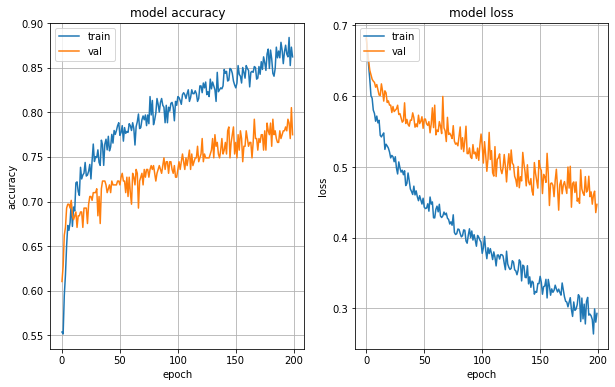

In [12]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.savefig(save_dir+'/end_result.pdf')

In [13]:
# model_path=save_dir+"new_weights.hdf5"
# new_model.load_weights(model_path)
y_predict=new_model.predict(x_test)

In [14]:
r=0
for i in range(y_predict.shape[0]):
    if y_predict[i]>0.5:
        y_predict[i]=1
    else:
        y_predict[i]=0
    if (y_predict[i]==y_test[i]):
        r=r+1
print (r/y_test.shape[0])      

0.7440476190476191


In [10]:
# performance visualization
def performance_visualization(labels, scores):
    p = Performance(labels, scores)
    print("confusion matrix")
    print(p.get_confusion_matrix())
    acc = p.accuracy()
    pre = p.precision()
    rec = p.recall()
    print('accuracy: %.2f' % acc)
    print('precision: %.2f' % pre)
    print('recall: %.2f' % rec)
    p.roc_plot()

# for classifier's performance evaluation
class Performance:

    def __init__(self, labels, scores, threshold=0.5):
        # true value of y
        self.labels = labels
        # predicted value of y
        self.scores = scores
        # classification threshold
        self.threshold = threshold
        self.db = self.get_db()
        self.TP, self.FP, self.FN, self.TN = self.get_confusion_matrix()

    def accuracy(self):
        return (self.TP + self.TN) / (self.TP + self.FN + self.FP + self.TN)

    def precision(self):
        return self.TP / (self.TP + self.FP)

    def recall(self):
        return self.TP / (self.TP + self.FN)

    def auc(self):
        auc = 0.
        prev_x = 0
        xy_arr = self.roc_coord()
        for x, y in xy_arr:
            if x != prev_x:
                auc += (x - prev_x) * y
                prev_x = x
        return auc

    # return coordinate of roc
    def roc_coord(self):
        xy_arr = []
        tp, fp = 0., 0.
        neg = self.TN + self.FP
        pos = self.TP + self.FN
        for i in range(len(self.db)):
            tp += self.db[i][0]
            fp += 1 - self.db[i][0]
            xy_arr.append([fp / neg, tp / pos])
        return xy_arr

    # plot roc
    def roc_plot(self):
        auc = self.auc()
        xy_arr = self.roc_coord()
        x = [_v[0] for _v in xy_arr]
        y = [_v[1] for _v in xy_arr]
        plt.title("ROC curve (AUC = %.4f)" % auc)
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        plt.plot(x, y)
        plt.grid()
        plt.savefig("train_model/ROC.pdf")
        plt.show()

    def get_db(self):
        db = []
        for i in range(len(self.labels)):
            db.append([self.labels[i], self.scores[i]])
        db = sorted(db, key=lambda x: x[1], reverse=True)
        return db

    # calculate confusion matrix
    def get_confusion_matrix(self):
        tp, fp, fn, tn = 0., 0., 0., 0.
        for i in range(len(self.labels)):
            if self.labels[i] == 1 and self.scores[i] >= self.threshold:
                tp += 1
            elif self.labels[i] == 0 and self.scores[i] >= self.threshold:
                fp += 1
            elif self.labels[i] == 1 and self.scores[i] < self.threshold:
                fn += 1
            else:
                tn += 1
        return [tp, fp, fn, tn]

confusion matrix
[118.0, 36.0, 50.0, 132.0]
accuracy: 0.74
precision: 0.77
recall: 0.70


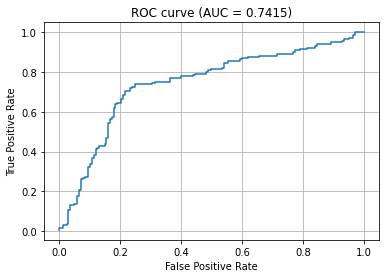

In [11]:
labels = y_test
scores = y_predict
performance_visualization(labels, scores)